<a href="https://colab.research.google.com/github/jesvin1/EPAT_TIMESERIES/blob/master/Make_a_Signal_Stationary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/time-series-forecasting-in-real-life-budget-forecasting-with-arima-d5ec57e634cb

#Importing Basics Packages

In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=607b109385447fdd1b019742dcb6d90027e78d70d0992090a8a38a93d0300590
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
# imports datetime for picking beginning and end dates for the analysis
import datetime
# imports yahoo finance for getting historical stock prices
import yfinance as yf
# imports pandas for dataframe manipulation
import pandas as pd
# imports numpy
import numpy as np
# for data visualization
import matplotlib as mpl
# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)
# for shorter lines with plotting
from matplotlib import pyplot as plt
# to hide warning messages
import warnings
warnings.filterwarnings('ignore')
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import coint

# sets the sample period as 5 years back from 09/12/2019
end = datetime.datetime(2020, 2, 11)
start = end - datetime.timedelta(days = 7*365)

#Declaring a Function for time series plot

In [0]:
def tsplot(y, lags=None, figsize=(10, 8), style='seaborn-bright'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax, linewidth=1.5)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return

#Getting Nifty 50 data from Yahoo

In [4]:
# gets the closing price fo Nifty 50 for the past 7 years
my_stock = yf.Ticker('^NSEI')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end)['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')
my_stock.head()


,close
Date,
2013-02-12,5922.50
2013-02-13,5932.95
2013-02-14,5896.95
2013-02-15,5887.40
2013-02-18,5898.20


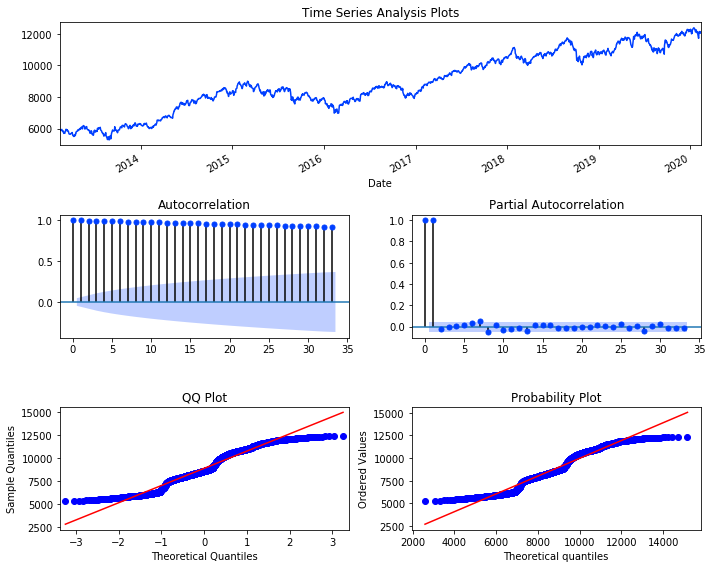

In [5]:
tsplot(my_stock.close)

Dickey-Fuller Test can help to find out that a time series is stationary or not. It is a statistical test, where the Null Hypothesis states there is a unit root for the given series, while the alternative hypothesis states that the series is stationary.

#Dickey-Fuller test, with the option of doing a log-transform.

In [0]:
# log_dataset: boolean indicating if we want to log-transform the dataset before running Augmented Dickey-Fuller test
def adf_test(dataset, log_dataset):
  ds = dataset
  if log_dataset:
    ds = dataset.apply(lambda x: np.log(x))
    ds.dropna(inplace=True)  
  result = adfuller(ds.close)  
  
  print('Augmented Dickey-Fuller Test')
  print('test statistic: %.10f' % result[0])
  print('p-value: %.10f' % result[1])
  print('critical values')  
  
  for key, value in result[4].items():
    print('\t%s: %.10f' % (key, value))

In [7]:
adf_test(my_stock,1)

Augmented Dickey-Fuller Test
test statistic: -1.0663849923
p-value: 0.7282893893
critical values
	1%: -3.4341889019
	5%: -2.8632356598
	10%: -2.5676727236


We can apply other techniques that transform the data, without changing its properties:

    Differencing subtract each data point by the value of a specific time point in the series, e.g., always subtract by the value of the next period
    
    Decomposition this technique is going to isolate each component of the time-series that was mentioned at the beginning (trend, seasonality, cycle, irregularity) and provide the residuals

#Differencing

In [23]:
# data: our dataset
# column_name: column to difference
n_diff_dataset = pd.DataFrame(data=np.diff(np.array(my_stock['close'])))
n_diff_dataset.columns = ['close']

# dropping NAN values
n_diff_dataset.dropna(inplace=True)
adf_test(n_diff_dataset,0)
#n_diff_dataset.head()

Augmented Dickey-Fuller Test
test statistic: -38.2938458998
p-value: 0.0000000000
critical values
	1%: -3.4341821529
	5%: -2.8632326806
	10%: -2.5676711373


In [0]:
# create a differenced series
def difference(dataset, interval=1):

	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

In [40]:
n_diff_dataset_1=difference(my_stock.close)
n_diff_dataset_1=pd.DataFrame(data=n_diff_dataset_1)
n_diff_dataset_1.columns=['close']
adf_test(n_diff_dataset_1,0)

Augmented Dickey-Fuller Test
test statistic: -38.2938458998
p-value: 0.0000000000
critical values
	1%: -3.4341821529
	5%: -2.8632326806
	10%: -2.5676711373


#Decomposes

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

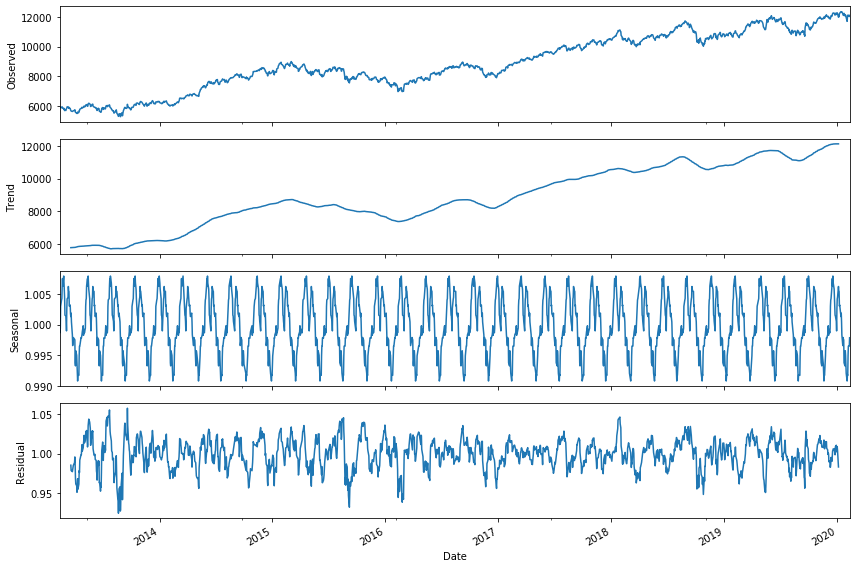

In [20]:
result = seasonal_decompose(my_stock, freq = 52, model='multiplicative')
result.plot()
pyplot.show()